# Zeropoints Comparison

## Environment: anaconda-2.7 

In [1]:
import sys
print sys.executable
# Hack!, this avoids messing with NERSC's config file for jupyter hub
sys.path.append('/global/homes/k/kaylanb/repos/astrometry.net')
print sys.path

/anaconda2/bin/python
['', '/anaconda2/lib/python27.zip', '/anaconda2/lib/python2.7', '/anaconda2/lib/python2.7/plat-linux2', '/anaconda2/lib/python2.7/lib-tk', '/anaconda2/lib/python2.7/lib-old', '/anaconda2/lib/python2.7/lib-dynload', '/global/homes/k/kaylanb/.local/lib/python2.7/site-packages', '/anaconda2/lib/python2.7/site-packages', '/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/global/u2/k/kaylanb/.ipython']


## Need more packages?

In [48]:
# Easy if pip, conda installable
#!/anaconda2/bin/pip install ...
#!/anaconda2/bin/conda install ...

# Main()

Run [legacy-zeropoints-qa.py](https://github.com/legacysurvey/legacypipe/blob/57fd01b80ed6af65543a1177798977da45975f3a/py/legacyccds/legacy-zeropoints.py) like this `"python legacy-zeropoints-qa.py"` to analyze everything. 

See below to walk through it step by step.

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import fitsio
import glob
import os

from astrometry.util.fits import fits_table, merge_tables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Merge tables
# a for Arjun, j for John
fns=glob.glob('/project/projectdirs/desi/users/burleigh/test_data/zeropoint*v2.fits')
j_cat,a_cat= [],[]
for fn in fns:
    j_cat.append( fits_table(fn) )
    a_fn= os.path.join(os.path.dirname(fn), 'arjun_'+os.path.basename(fn))
    a_cat.append( fits_table(a_fn) )
j = merge_tables(j_cat, columns='fillzero')
a = merge_tables(a_cat, columns='fillzero')

In [41]:
print "rows: John=%d, Arjun=%d" % (len(j),len(a))
print "cols: John=%d, Arjun=%d" % (len(j.get_columns()),len(a.get_columns()))

def pset(s):
    print np.sort(list(s))

sj,sa= set(j.get_columns()),set(a.get_columns())
print "Both:\n",pset(sj.intersection(sa))
print "Arjun Only:\n",pset(sa.difference(sj))
print "John Only:\n",pset(sj.difference(sa))

rows: John=148, Arjun=148
cols: John=47, Arjun=59
Both:
['airmass' 'avsky' 'ccdname' 'cd1_1' 'cd1_2' 'cd2_1' 'cd2_2' 'crpix1'
 'crpix2' 'crval1' 'crval2' 'date_obs' 'dec' 'expnum' 'exptime' 'filter'
 'ha' 'mjd_obs' 'object' 'propid' 'ra' 'ut' 'zpt']
None
Arjun Only:
['arawgain' 'badimg' 'ccddec' 'ccddecoff' 'ccddecrms' 'ccdhdunum'
 'ccdmdncol' 'ccdnmatch' 'ccdnmatcha' 'ccdnmatchb' 'ccdnmatchc'
 'ccdnmatchd' 'ccdnstar' 'ccdnum' 'ccdphoff' 'ccdphrms' 'ccdra' 'ccdraoff'
 'ccdrarms' 'ccdskycounts' 'ccdskymag' 'ccdskyrms' 'ccdtransp' 'ccdzpt'
 'ccdzpta' 'ccdzptb' 'ccdzptc' 'ccdzptd' 'filename' 'fwhm' 'naxis1'
 'naxis2' 'psfab' 'psfpa' 'seeing' 'temp']
None
John Only:
['camera' 'dec_bore' 'decoff' 'decrms' 'expid' 'gain' 'height'
 'image_filename' 'image_hdu' 'mdncol' 'nmatch' 'nstar' 'phoff' 'phrms'
 'pixscale' 'ra_bore' 'raoff' 'rarms' 'skycounts' 'skymag' 'skyrms'
 'transp' 'width' 'zptavg']
None


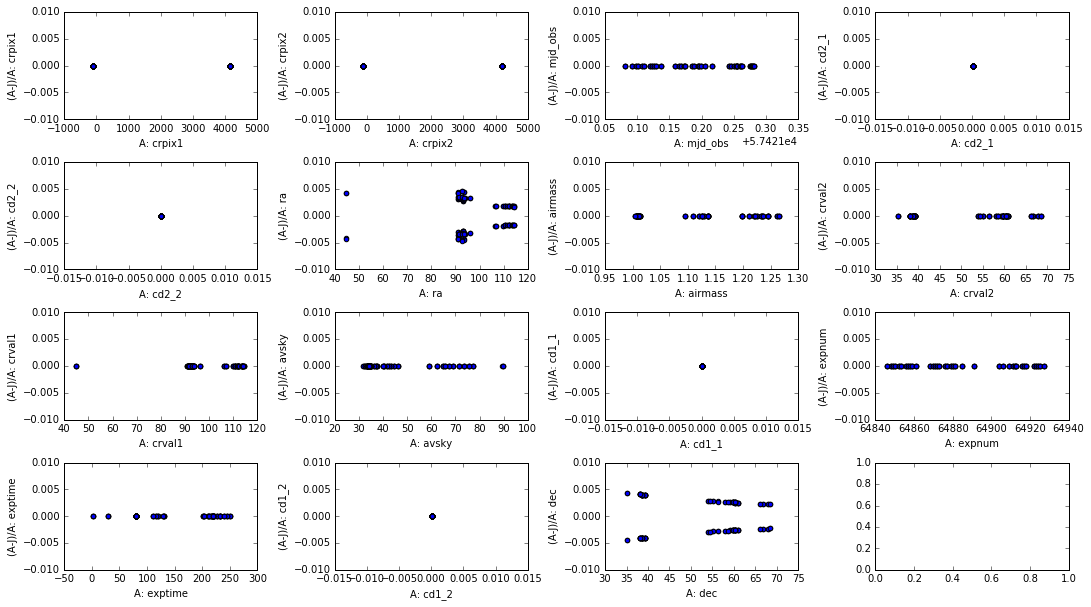

In [42]:
# Keys with SAME NAME
fig,axes= plt.subplots(4,4,figsize=(18,10))
ax=axes.flatten()
hw=0.4
plt.subplots_adjust(hspace=hw,wspace=hw)
cnt=-1
for key in sj.intersection(sa):
    if key in ['date_obs','filter','object','propid','ccdname']:
        continue
    if key in ['ha','ut']:
        continue
    if key in ['zpt']:
        continue #A zpt not -> J zpt
    cnt+=1
    y= (a.get(key) - j.get(key))/a.get(key)
    ax[cnt].scatter(a.get(key),y) 
    xlab=ax[cnt].set_xlabel('A: %s' % key)
    ylab=ax[cnt].set_ylabel('(A-J)/A: %s' % key)
    ax[cnt].set_ylim([-0.01,0.01])
plt.savefig("same_keys.png",\
            bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)
    

## Mapping between Arjun's and John's keys

Use the `%%file` magic function to save code to a file `maps.py`. We can then import it as a **module** 

In [50]:
%%file maps.py

def a2j(key):
    d= dict(arawgain='gain',\
            ccddec='dec_bore',\
            ccdra='ra_bore',\
            ccddecoff='decoff',\
            ccdraoff='raoff',\
            ccddecrms='decrms',\
            ccdrarms='rarms',\
            ccdhdunum='image_hdu',\
            ccdmdncol='mdncol',\
            ccdnmatch='nmatch',\
            ccdnstar='nstar',\
            ccdphoff='phoff',\
            ccdphrms='phrms',\
            ccdskycounts='skycounts',\
            ccdskymag='skymag',\
            ccdskyrms='skyrms',\
            ccdtransp='transp',\
            ccdzpt='zpt',\
            zpt='zptavg',\
            filename='image_filename',\
            naxis1='width',\
            naxis2='height')
    return d[key]

def lims_for_key(key):
    d= dict(arawgain=0.05,\
            ccddec=0.05,\
            ccdra=0.05,\
            ccddecoff='none',\
            ccdraoff='none',\
            ccddecrms='none',\
            ccdrarms='none',\
            ccdhdunum='none',\
            ccdmdncol=0.15,\
            ccdnmatch='none',\
            ccdnstar='none',\
            ccdphoff='none',\
            ccdphrms='none',\
            ccdskycounts='none',\
            ccdskymag='none',\
            ccdskyrms='none',\
            ccdtransp='none',\
            ccdzpt=0.05,\
            zpt=0.02,\
            filename='none',\
            naxis1='none',\
            naxis2='none')
    return d[key]

def a_not_in_j():
    return ['badimg','ccdnum',\
          'ccdnmatcha','ccdnmatchb','ccdnmatchc','ccdnmatchd',\
          'ccdzpta','ccdzptb','ccdzptc','ccdzptd',\
          'fwhm','psfab','psfpa','seeing','temp']
    
def j_not_in_a():
    return ['camera','expid','pixscale']

Overwriting maps.py


cnt=19


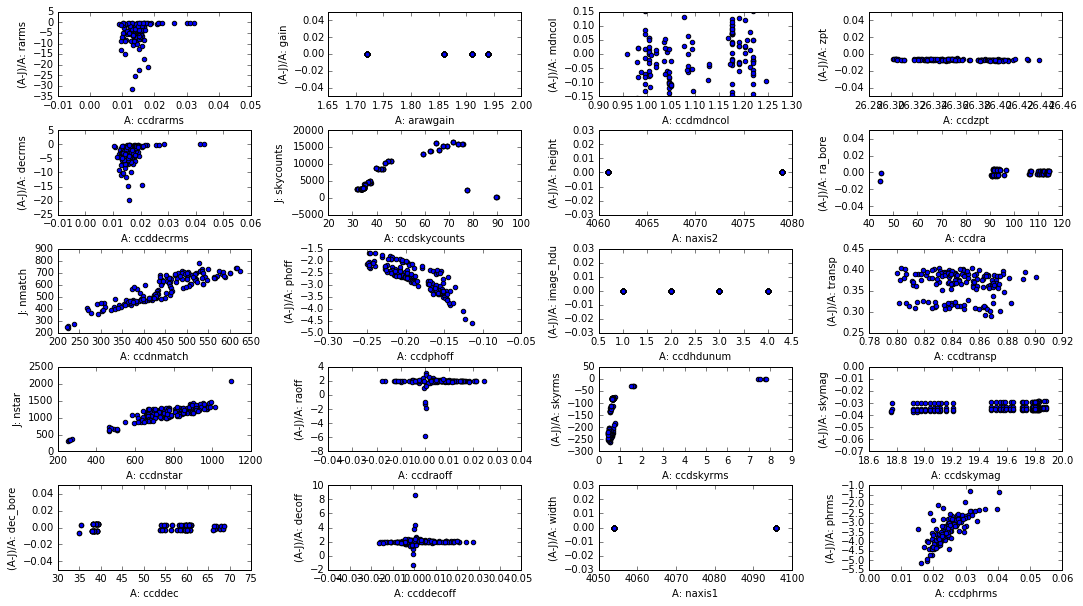

In [45]:
# SAME DATA, Different keys
import maps
fig,axes= plt.subplots(5,4,figsize=(18,10))
ax=axes.flatten()
hw=0.4
plt.subplots_adjust(hspace=hw,wspace=hw)
cnt=-1
# Arjun only
for key in sa.difference(sj):
    #avoid= 
    if key in maps.a_not_in_j():
        continue
    if key in ['filename']:
        continue
    cnt+=1
    if key in ['ccdnmatch','ccdnstar','ccdskycounts']:
        y= j.get( maps.a2j(key) )
        ax[cnt].scatter(a.get(key),y) 
        xlab=ax[cnt].set_xlabel('A: %s' % key)
        ylab=ax[cnt].set_ylabel('J: %s' % maps.a2j(key) )
    else:
        y= (a.get(key) - j.get( maps.a2j(key) ))/a.get(key)
        ax[cnt].scatter(a.get(key),y) 
        xlab=ax[cnt].set_xlabel('A: %s' % key)
        ylab=ax[cnt].set_ylabel('(A-J)/A: %s' % maps.a2j(key) )
    ylim= maps.lims_for_key(key)
    if ylim != 'none':
        ax[cnt].set_ylim([-ylim,ylim])
plt.savefig("same_data_diff_keys.png",\
            bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)
print "cnt=%d" % cnt

In [46]:
# If STRINGS not identicial, print them 
same= ['date_obs','filter','object','propid','ccdname','ha','ut']
mapped= ['filename']
for key in same:
    if a.get(key)[0] != j.get(key)[0]:
        print "Arjuns, Johns (%s)" % key
        for i in range(4): print a.get(key)[i],j.get(key)[i]
for key in mapped:
    if a.get(key)[0] != j.get( maps.a2j(key) )[0]:
        print "Arjuns, Johns (%s)" % key
        for i in range(4): print a.get(key)[i],j.get( maps.a2j(key) )[i]


Arjuns, Johns (ccdname)
ccd1 CCD1
ccd2 CCD2
ccd3 CCD3
ccd4 CCD4
Arjuns, Johns (filename)
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201


In [47]:
# Totally DIFFERENT keys, print them
print "Arjun:"
for key in maps.a_not_in_j():
    print "%s: " % key, a.get(key)[0]
    
print "\nJohn:"
for key in maps.j_not_in_a():
    print "%s: " % key, j.get(key)[0]

Arjun:
badimg:  0
ccdnum:  1
ccdnmatcha:  100
ccdnmatchb:  95
ccdnmatchc:  117
ccdnmatchd:  117
ccdzpta:  26.372
ccdzptb:  26.3575
ccdzptc:  26.3725
ccdzptd:  26.3681
fwhm:  1.999
psfab:  1.0948
psfpa:  113.972
seeing:  2.23042
temp:  -0.9

John:
camera:  mosaic3
expid:  00021214-CCD1
pixscale:  0.259628
